In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import differential_evolution, brentq

np.random.seed(42)
data=pd.read_csv("flare_data.csv")
data

,t,s
0,0.000000,-5.238910
1,0.003502,0.218728
2,0.007004,-3.168850
3,0.010505,6.814310
4,0.014007,-3.293350
...,...,...
1995,6.985990,-1.123620
1996,6.989490,6.048450
1997,6.993000,-0.651804
1998,6.996500,-2.635930


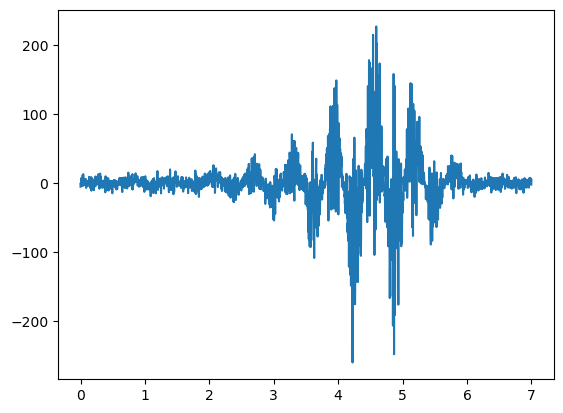

<Figure size 640x480 with 0 Axes>

In [2]:
t_data=data['t']
y_data=data['s']
plt.plot(t_data,y_data)
plt.show()
plt.clf()

In [3]:

def intensity_model(t, A, T, w):
    # s(t) = A * exp(t) * (1 - tanh(2*(t - T))) * sin(w * t)
    return A * np.exp(t) * (1 - np.tanh(2 * (t - T))) *np.sin(w * t)


def log_P0D(theta, t, y, yerr):
    A, T, w = theta

    #range of parameters must be satisfied
    if not (0 < A < 2 and 1 < T < 10 and 1 < w < 20):
        return -np.inf
    
    y_model = intensity_model(t, A, T, w)

    #Since P(0) is uniform for all values within the range
    chi2 =np.sum(((y - y_model) / yerr) ** 2)
    return -1*chi2



In [4]:
#--------------------------------------------#
#             CALCULATE FLOOR NOISE          #
#--------------------------------------------#
y_std_const = np.std(y_data)

def get_global_min_chi2(k):

    k = abs(k)
    y_err = 0.2 * np.abs(y_data) + k * y_std_const

    def loss(theta):
        a, b, g = theta
        model = intensity_model(t_data, a, b, g)
        return np.sum(((y_data - model) / y_err)**2)
    
    bounds = [(0.0, 2.0), (1.0, 10.0), (1.0, 20.0)]
    res = differential_evolution(loss, bounds, strategy='best1bin', 
                                 popsize=15, tol=0.01, seed=42)
    
    chi2 = res.fun
    dof = len(y_data) - 3
    return chi2 / dof, res.x

def target_function(k):
    # We want Reduced Chi2 - 1.0 = 0
    r_chi2, _ = get_global_min_chi2(k)
    return r_chi2 - 1.0

print("Finding Optimal Noise Floor...")
optimal_k = brentq(target_function, 0.1, 1.0, xtol=1e-3)

print(f"Optimal k: {optimal_k:.4f}")
final_rchi2, final_params = get_global_min_chi2(optimal_k)
#also calculate optimal parameters : (just for reference)
print(f"Final Params: {final_params}")



Finding Optimal Noise Floor...


Optimal k: 0.3746
Final Params: [ 0.24321711  5.06788887 10.00060175]


In [5]:
#--------NEW ERROR FUNCTION, ACCOUNTING FOR FLOOR NOISE------
y_err = 0.20 * np.abs(y_data)+optimal_k*y_std_const

reduced_chi2=-1*(log_P0D(final_params,t_data,y_data,y_err))/(len(y_data)-3)
reduced_chi2

np.float64(0.9999370697826252)

In [6]:

#____________________________________________________________________________________________#
# 3. Robbins-Monro MCMC Algorithm (TO FIRST find the covariance matrix of A,T,w)             #
#____________________________________________________________________________________________#

def run_robbins_monro_mcmc(t, y, yerr, n_iterations=40000):
    
    current_theta = np.array([1.0, 5.0, 10.0]) # Start in valid range
    current_log_prob = log_P0D(current_theta, t, y, yerr)
    log_sigma = np.log([0.1, 0.1, 0.1]) 
    
    samples = np.zeros((n_iterations, 3))
    sigmas=np.zeros((n_iterations,3))
    accepted_counts = np.zeros(3) 

    # Robbins-Monro hyperparameters
    target_acceptance = 0.44  # good rate for 1D updates
    decay_power = 0.7         # 'kappa' 0.7 for fast decay
    
    print("Starting Robbins-Monro MCMC...")
    
    for i in range(n_iterations):
        w_n = 1.0 / ((i + 1) ** decay_power)
        
        # Component-wise Update (since the variables may be correlated)
        for j in range(3):
            sigma_j = np.exp(log_sigma[j])
            
            proposed_theta = current_theta.copy()
            proposed_theta[j] += np.random.normal(0, sigma_j)
            
            proposed_log_prob = log_P0D(proposed_theta, t, y, yerr)
            log_ratio = proposed_log_prob - current_log_prob
            
            # Accept/Reject
            accepted = 0
            if np.log(np.random.rand()) < log_ratio:
                current_theta[j] = proposed_theta[j]
                current_log_prob = proposed_log_prob
                accepted = 1
                accepted_counts[j] += 1
            
            # tune sigma
            sigmas[i][j]=sigma_j
            log_sigma[j] += w_n * (accepted - target_acceptance)
        
        samples[i] = current_theta

    return samples, np.exp(log_sigma), accepted_counts / n_iterations, sigmas


iterations=10000
chain, final_sigmas, rates, all_sigmas = run_robbins_monro_mcmc(t_data, y_data, y_err,iterations)


Starting Robbins-Monro MCMC...


In [7]:

print("\n" + "="*30)
print("FINAL RESULTS")
print("="*30)
print(f"Final Step Sizes (Sigmas):")
print(f"  A: {final_sigmas[0]:.5f}")
print(r"$/tau$:",f"{final_sigmas[1]:.5f}")
print(r"$/omega$:",f"{final_sigmas[2]:.5f}")
print("-" * 30)
print(f"Final Acceptance Rates (Target: 44%):")
print(f"  A: {rates[0]:.2%}")
print(r"$/tau$:",f"{rates[1]:.2%}")
print(r"$/omega$:",f"{rates[2]:.2%}")
print("="*30)



FINAL RESULTS
Final Step Sizes (Sigmas):
  A: 0.01524
$/tau$: 0.04349
$/omega$: 0.01170
------------------------------
Final Acceptance Rates (Target: 44%):
  A: 43.24%
$/tau$: 43.66%
$/omega$: 43.81%


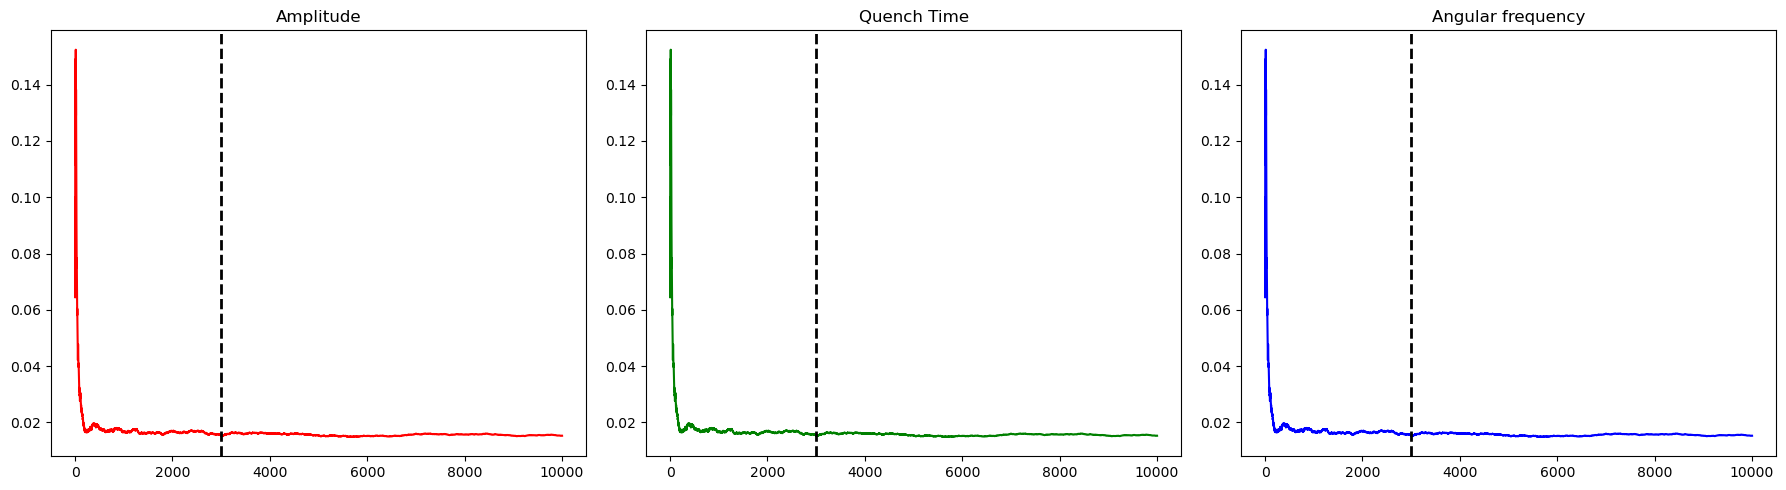

In [8]:

burn_in=3000

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].set_title("Amplitude")
axes[0].plot(np.arange(iterations),all_sigmas[:,0],'r')

axes[1].set_title("Quench Time")
axes[1].plot(np.arange(iterations),all_sigmas[:,0],'g')

axes[2].set_title("Angular frequency")
axes[2].plot(np.arange(iterations),all_sigmas[:,0],'b')


axes[0].axvline(x=burn_in, color='black', linestyle='--', linewidth=2)

axes[1].axvline(x=burn_in, color='black', linestyle='--', linewidth=2)

axes[2].axvline(x=burn_in, color='black', linestyle='--', linewidth=2)

fig.tight_layout()
fig.savefig("./output/Sigma_burnin.jpg")

#--3000 is the ideal burn in phase as sigma barely varies after that


In [9]:
import numpy as np
import matplotlib.pyplot as plt

covariance_matrix = np.cov(chain[5000:].T)
proposal_cov = covariance_matrix * (2.38**2 / 3)
#get covariance matrix through Robbin-Monro MCMC and use it to get better results on our standard MH MCMC
def run_standard_block_mh(t, y, yerr, n_iterations=20000, cov_matrix=None):
    
    # Start at the mean of your previous results (Best guess)
    #current_theta = np.mean(chain[5000:], axis=0)
    # OR start at the middle 
    current_theta=np.array([1,5,10])
    
    current_log_prob = log_P0D(current_theta, t, y, yerr)
    
    samples = np.zeros((n_iterations, 3))
    accepted = 0
    
    print("Starting Standard Block Metropolis-Hastings...")
    
    for i in range(n_iterations):
 
        proposed_theta = np.random.multivariate_normal(current_theta, cov_matrix)
        
        #reject out of bounds
        if not (0 < proposed_theta[0] < 2 and 
                1 < proposed_theta[1] < 10 and 
                1 < proposed_theta[2] < 20):

            samples[i] = current_theta
            continue

        # Calculate Ratio
        proposed_log_prob = log_P0D(proposed_theta, t, y, yerr)
        log_ratio = proposed_log_prob - current_log_prob
        
        # Accept/Reject
        if np.log(np.random.rand()) < log_ratio:
            current_theta = proposed_theta
            current_log_prob = proposed_log_prob
            accepted += 1
            
        samples[i] = current_theta

    print(f"Finished. Acceptance Rate: {accepted / n_iterations:.2%}")
    return samples

# Run it
MH_iterations=400000
final_chain = run_standard_block_mh(t_data, y_data, y_err, 
                                    n_iterations=MH_iterations, 
                                    cov_matrix=proposal_cov)


Starting Standard Block Metropolis-Hastings...
Finished. Acceptance Rate: 33.00%


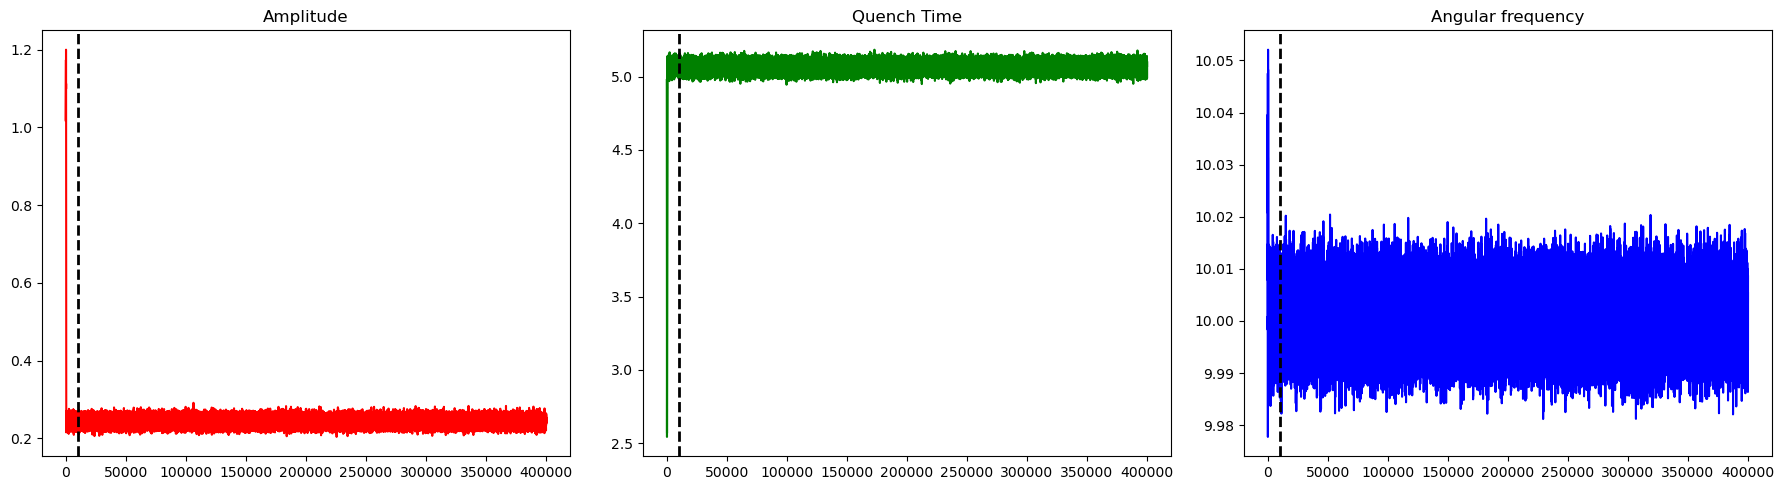

In [10]:
#--------------------------#
#        TRACE PLOTS       #
#--------------------------#

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
consider_from=10000
axes[0].set_title("Amplitude")
axes[0].plot(np.arange(MH_iterations),final_chain[:,0],'r')

axes[1].set_title("Quench Time")
axes[1].plot(np.arange(MH_iterations),final_chain[:,1],'g')

axes[2].set_title("Angular frequency")
axes[2].plot(np.arange(MH_iterations),final_chain[:,2],'b')


axes[0].axvline(x=consider_from, color='black', linestyle='--', linewidth=2)

axes[1].axvline(x=consider_from, color='black', linestyle='--', linewidth=2)

axes[2].axvline(x=consider_from, color='black', linestyle='--', linewidth=2)

fig.tight_layout()

fig.savefig("./output/Traceplot.jpg")


C:\Users\Aneesh Shastri\AppData\Local\Temp\ipykernel_5908\3617236161.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


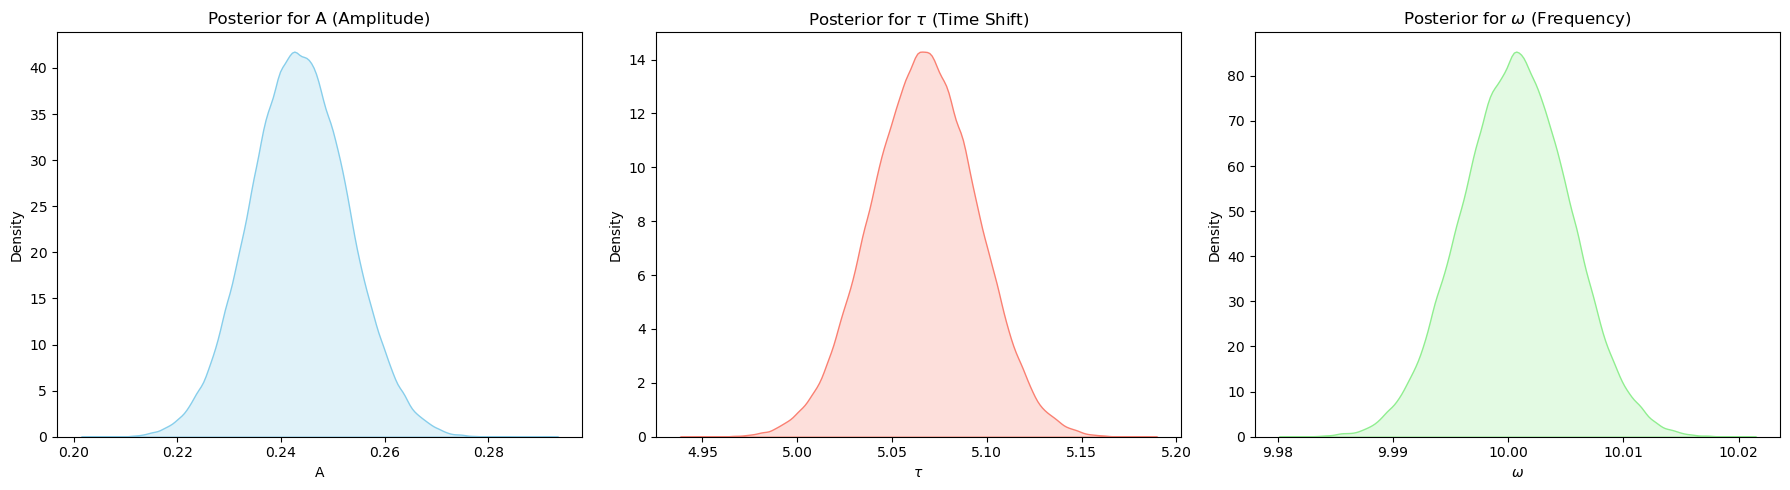

In [11]:
final_chain = final_chain[consider_from:] 

df = pd.DataFrame(final_chain, columns=['A', r'$\tau$', r'$\omega$'])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 3. Plot KDE for each parameter

# A
sns.kdeplot(data=df, x='A', ax=axes[0], fill=True, color='skyblue')
axes[0].set_title('Posterior for A (Amplitude)')

# T
sns.kdeplot(data=df, x=r'$\tau$', ax=axes[1], fill=True, color='salmon')
axes[1].set_title(r'Posterior for $\tau$ (Time Shift)')

# w
sns.kdeplot(data=df, x=r'$\omega$', ax=axes[2], fill=True, color='lightgreen')
axes[2].set_title(r'Posterior for $\omega$ (Frequency)')

fig.tight_layout()
fig.show()

fig.savefig("./output/posterior_distribution.jpg")

In [12]:
#-----(MAP ESTIMATION)-------
from scipy.stats import gaussian_kde
import numpy as np
#---(My probability distribution resembles guassian distribution enough for me to use guassian kde)--
kde_A = gaussian_kde(final_chain[:,0])
kde_T = gaussian_kde(final_chain[:,1])
kde_w = gaussian_kde(final_chain[:,2])

grid_A = np.linspace(min(final_chain[:,0]), max(final_chain[:,0]), 1000)
grid_T = np.linspace(min(final_chain[:,1]), max(final_chain[:,1]), 1000)
grid_w = np.linspace(min(final_chain[:,2]), max(final_chain[:,2]), 1000)

map_estimate_A = grid_A[np.argmax(kde_A(grid_A))]
map_estimate_T = grid_T[np.argmax(kde_T(grid_T))]
map_estimate_w = grid_w[np.argmax(kde_w(grid_w))]



In [13]:
#== calculate final reduced chi squared
map_params=[map_estimate_A,map_estimate_T,map_estimate_w]
reduced_chi2=-1*(log_P0D(map_params,t_data,y_data,y_err))/(len(y_data)-3)
reduced_chi2

np.float64(0.9999485542587325)

Parameter Estimates (MAP):
A: 0.2426 +/- 0.0095
$\tau$: 5.066 +/- 0.0280
$\omega$: 10.001 +/- 0.0047


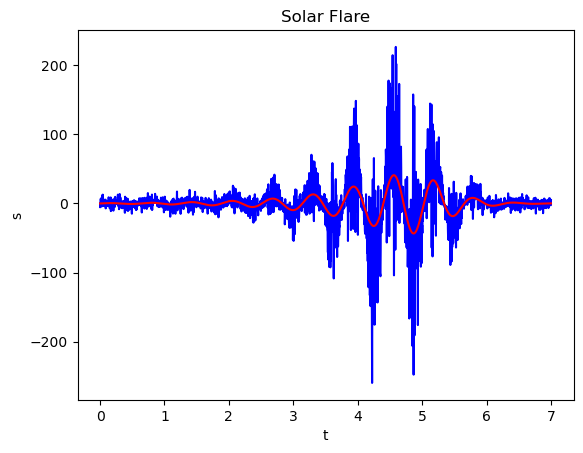

In [18]:

'''
-------------------------------------------------
==================MAP ESTIMATES==================
-------------------------------------------------
'''
print("Parameter Estimates (MAP):")
print(f"A: {map_estimate_A:.4f} +/- {np.std(final_chain[:,0]):.4f}")
print(r'$\tau$:',f"{map_estimate_T:.3f} +/- {np.std(final_chain[:,1]):.4f}")
print(r"$\omega$:",f"{map_estimate_w:.3f} +/- {np.std(final_chain[:,2]):.4f}")

y_signal=intensity_model(t_data,map_estimate_A,map_estimate_T,map_estimate_w)
plt.plot(t_data,y_data,'b')
plt.plot(t_data,y_signal,'r')
plt.title("Solar Flare")
plt.xlabel("t")
plt.ylabel("s")
plt.savefig("./output/fit_check.jpg")